In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectorbt as vbt
import datetime as dt
import yfinance as yf

In [3]:
#loading data
msft = yf.download("MSFT", "2023-01-01", "2023-12-31", interval="1h")
msft.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1744 entries, 2023-01-03 09:30:00-05:00 to 2023-12-29 15:30:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1744 non-null   float64
 1   High       1744 non-null   float64
 2   Low        1744 non-null   float64
 3   Close      1744 non-null   float64
 4   Adj Close  1744 non-null   float64
 5   Volume     1744 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 95.4 KB


<Axes: >

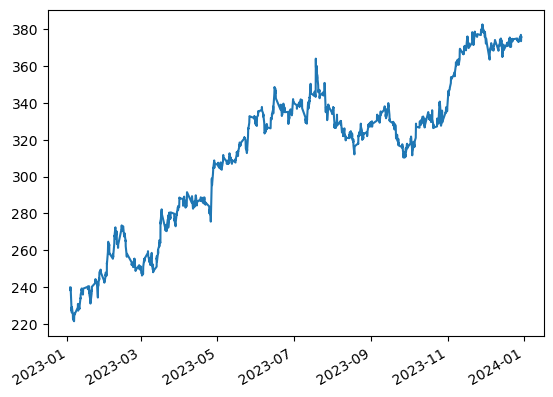

In [4]:
#plotting data
msft["Close"].plot()

In [5]:
# initializing df for organization
df = pd.DataFrame()
df["closes"] = msft["Close"].groupby(msft.index.floor("d")).apply(list)
df["open"] = [x[0] for x in msft["Open"].groupby(msft.index.floor("d")).apply(list)]
df.index = pd.to_datetime(df.index.date)

# dropping because of missing data
df = df.drop(["2023-07-03", "2023-11-24"], axis=0)

In [6]:
# finding hourly move
def move(closes, open):
    return [np.abs(close/open - 1) for close in closes]

df["moves"] = df.apply(lambda x: move(x["closes"], x["open"]), axis=1)

In [18]:
# moving average of move values
def moving_average(data, n=14):
    ma = []
    for i in range(len(data)):
        if i < n:
            ma.append(data[i])
        else:
            window = data[i-n:i]
            ma.append(sum(window) / n)
    return ma

move_arr = np.stack(df["moves"].values)
open_arr = np.array([[val] * 7 for val in df["open"]])

avg_move_arr = np.apply_along_axis(moving_average, axis=0, arr=move_arr)

df["upper_bound"] = (open_arr * (1 + avg_move_arr)).tolist()
df["lower_bound"] = (open_arr * (1 - avg_move_arr)).tolist()

In [65]:
len(df) * 7

1736

In [81]:
baddate1 = msft.index.date != pd.Timestamp("2023-07-03").date()
baddate2 = msft.index.date != pd.Timestamp("2023-11-24").date()

flat = pd.DataFrame(
    {"date": msft.index[baddate1 & baddate2],
     "close": np.stack(df["closes"]).flatten(),
     "upper_bound": np.stack(df["upper_bound"]).flatten(),
     "lower_bound": np.stack(df["lower_bound"]).flatten()}
)

flat = flat.set_index(["date"])
flat.head(1)

,close,upper_bound,lower_bound
date,,,
2023-01-03 09:30:00-05:00,239.788101,246.371902,239.788101
